In [381]:
# Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import sklearn
import xgboost

# Remove all kind of warnings
import warnings
from warnings import simplefilter
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

In [382]:
# data input
df_train = pd.read_csv("/Users/tram/Documents/Learning/bm/train.csv", delimiter=";", index_col=None)
df_test = pd.read_csv("/Users/tram/Documents/Learning/bm/test.csv", delimiter=";", index_col=None)
print("Number of instance in train set:", len(df_train))
print("Number of instance in test set:", len(df_test))

Number of instance in train set: 45211
Number of instance in test set: 4521


The test set is 10% randomly extracted from the train set. Those dataset should be detected and remove away to ensure the prediction accuracy of the train set.

In [383]:
train_test_merged = pd.merge(df_train, df_test, on = list(df_train.columns), how = 'left', indicator='exist')
df_train = train_test_merged.loc[train_test_merged['exist'] != 'both'].drop('exist', axis = 1).reset_index(drop=True)
print("Number of instances in train set after removing test set:", len(df_train))

Number of instances in train set after removing test set: 40690


## EDA on train set

In [384]:
df_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


**Detailed Column Descriptions**

bank client data:

1 - age (numeric)

2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
"blue-collar","self-employed","retired","technician","services")

3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)

4 - education (categorical: "unknown","secondary","primary","tertiary")

5 - default: has credit in **default**? (binary: "yes","no")

6 - balance: average yearly balance, in euros (numeric)

7 - housing: has housing loan? (binary: "yes","no")

8 - loan: has personal loan? (binary: "yes","no")

**related with the last contact of the current campaign:**

9 - contact: contact communication type (categorical: "unknown","telephone","cellular")

10 - day: last contact day of the month (numeric)

11 - month: last contact month of year (categorical: "jan", "feb", "mar", …, "nov", "dec")

12 - duration: last contact duration, in seconds (numeric)

**other attributes:**

13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)

15 - previous: number of contacts performed before this campaign and for this client (numeric)

16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

**Output variable (desired target):**

17 - y - has the client subscribed a term deposit? (binary: "yes","no")

In [385]:
# Check NULL values on train set
df_train.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [386]:
# Check NULL values on test set
df_test.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [387]:
# class encoding into binary format
def class_encoding(df):
    df = df.rename(columns={'y': 'buy'})
    df.loc[df['buy'] == 'yes', 'buy'] = 1
    df.loc[df['buy'] == 'no', 'buy'] = 0
    df['buy'] = df['buy'].astype('category')

    return df

df_train = class_encoding(df_train)
df_test = class_encoding(df_test)

In [388]:
# class ratio
def class_ratio(df):
    class_ratio = pd.DataFrame({'label' : list(df['buy'].value_counts().keys()),
                                'count' : list(df['buy'].value_counts().values)
                                })
    class_ratio['percent'] = class_ratio['count'].apply(lambda x: round(x/class_ratio['count'].sum(), 2))
    return class_ratio

print("Class ratio on train set:")
class_ratio(df_train)

Class ratio on train set:


,label,count,percent
0,0,35922,0.88
1,1,4768,0.12


In [389]:
print("Class ratio on test set:")
class_ratio(df_test)

Class ratio on test set:


,label,count,percent
0,0,4000,0.88
1,1,521,0.12


In [390]:
# transform unit of last contact duration, from second to minute, get the value of minute unit
df_train = df_train.rename(columns={'duration': 'duration_sec'})
df_train['duration_min'] = df_train['duration_sec'].apply(lambda x: round(x/60, 2))
df_train = df_train.drop('duration_sec', axis = 1)

df_test = df_test.rename(columns={'duration': 'duration_sec'})
df_test['duration_min'] = df_test['duration_sec'].apply(lambda x: round(x/60, 2))
df_test = df_test.drop('duration_sec', axis = 1)

In [391]:
# general distribution of all attributes
df_train.describe()

,age,balance,day,campaign,pdays,previous,duration_min
count,40690.000000,40690.000000,40690.000000,40690.000000,40690.000000,40690.000000,40690.000000
mean,40.910224,1355.562694,15.794323,2.760531,40.245736,0.584517,4.291991
std,10.623291,3048.606598,8.330759,3.096729,100.130708,2.361480,4.287715
min,18.000000,-8019.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,73.000000,8.000000,1.000000,-1.000000,0.000000,1.720000
50%,39.000000,449.000000,16.000000,2.000000,-1.000000,0.000000,3.000000
75%,48.000000,1422.000000,21.000000,3.000000,-1.000000,0.000000,5.300000
max,95.000000,102127.000000,31.000000,63.000000,854.000000,275.000000,81.970000


In [392]:
# Categorize features into groups for easily visualizing. There are 2 groups: categorical & numeric.
client_num_cols = ['age', 'balance']
client_cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan']

curr_campaign_num_cols = ['duration_min', 'campaign']
curr_campaign_cat_cols = ['contact', 'day', 'month']

last_campaign_num_cols = ['pdays', 'previous']
last_campaign_cat_cols = ['poutcome']

In [393]:
# Plotting Functions
def num_plot(data = None, col = None, class_ = None, value_range = [], plot_type = 'density', figsize = (20,6)):
    if len(value_range) > 0:
        data_plotted = data.loc[(data[col] >= value_range[0]) & (data[col] <= value_range[1])]
    else:
        data_plotted = data

    fig, axes = plt.subplots(1, 2, figsize = figsize)
    if plot_type == 'density':
        sns.kdeplot(data = data_plotted, x = col, hue = class_, ax = axes[0])
    elif plot_type == 'hist':
        sns.histplot(data = data_plotted, x = col, hue = class_, ax = axes[0])
    sns.boxplot(data = data_plotted, x = col, y = class_, ax = axes[1])
    print(col)
    print(data_plotted.groupby([class_])[col].describe(), "\n")
    return axes


def cat_plot(data = None, col = None, class_ = None, figsize = (20,6)):
    # Plot 1
    count_df = pd.DataFrame(data.groupby([col] + [class_])[col].count())
    count_df.columns = ['count']
    count_df = count_df.reset_index().sort_values(by='count', ascending=False)

    fig, axes = plt.subplots(1, 2, figsize=figsize)
    sns.barplot(data = count_df, x = col, y = 'count', hue = class_, ax = axes[0])
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation = 90)

    # Plot 2
    pivot_df = count_df.pivot_table(index=col, columns=class_, values='count', aggfunc='sum').reset_index()
    pivot_df['count_all'] = pivot_df.apply(lambda x: x[0] + x[1], axis = 1)
    pivot_df['percent_1'] = pivot_df.apply(lambda x: round(x[1]/x['count_all'], 2), axis = 1)
    pivot_df = pivot_df.sort_values(by='percent_1', ascending=False)

    sns.barplot(data = pivot_df, x = col, y = 'percent_1', color='#47A992', ax = axes[1])
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation = 90)

    return axes, pivot_df

### About the client's profile

age
       count       mean        std   min   25%   50%   75%   max
buy                                                             
0    35922.0  40.821279  10.170897  18.0  33.0  39.0  48.0  95.0
1     4768.0  41.580327  13.537192  18.0  31.0  38.0  50.0  95.0 

balance
       count         mean          std     min    25%    50%      75%  \
buy                                                                     
0    35922.0  1292.635766  2962.555417 -8019.0   58.0  417.0  1342.00   
1     4768.0  1829.652685  3597.095353 -3058.0  215.0  734.0  2156.75   

          max  
buy            
0    102127.0  
1     81204.0   



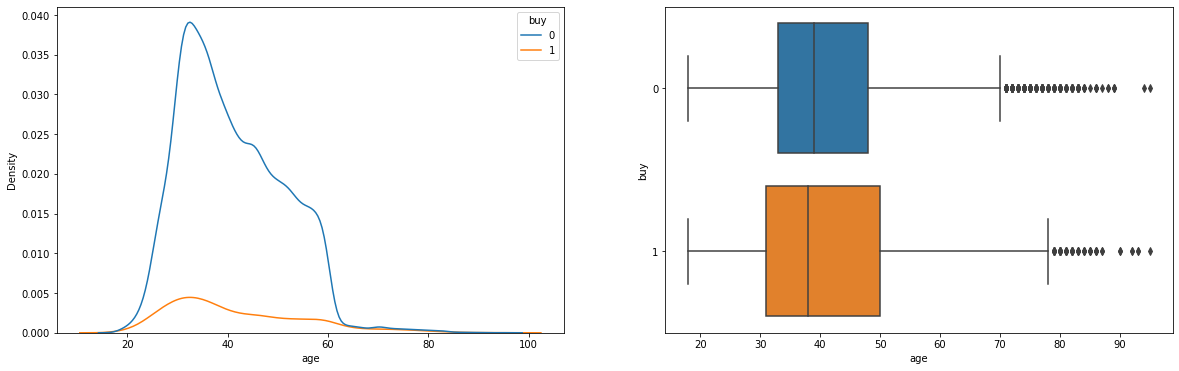

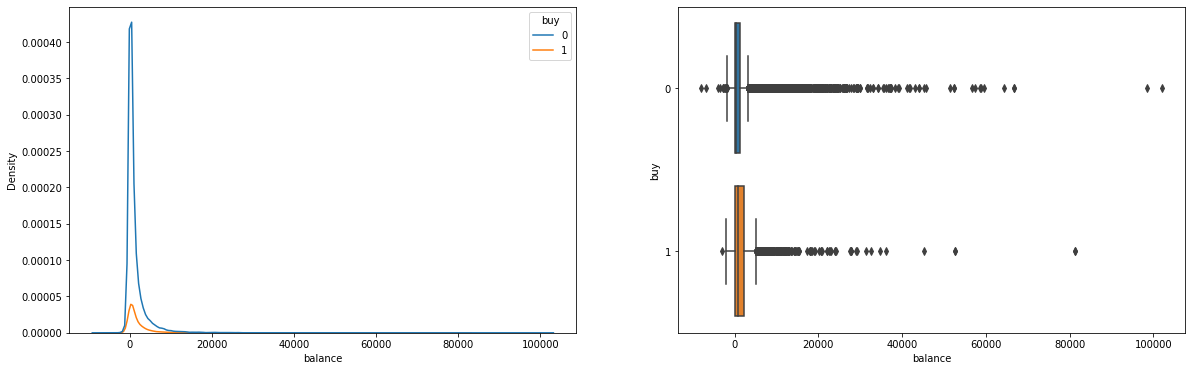

In [394]:
for col in client_num_cols:
    num_plot(data = df_train, col = col, class_ = 'buy')

There are some negative values for balance. These cases can happen if the account owner has some amount of payment over than their available balance. 

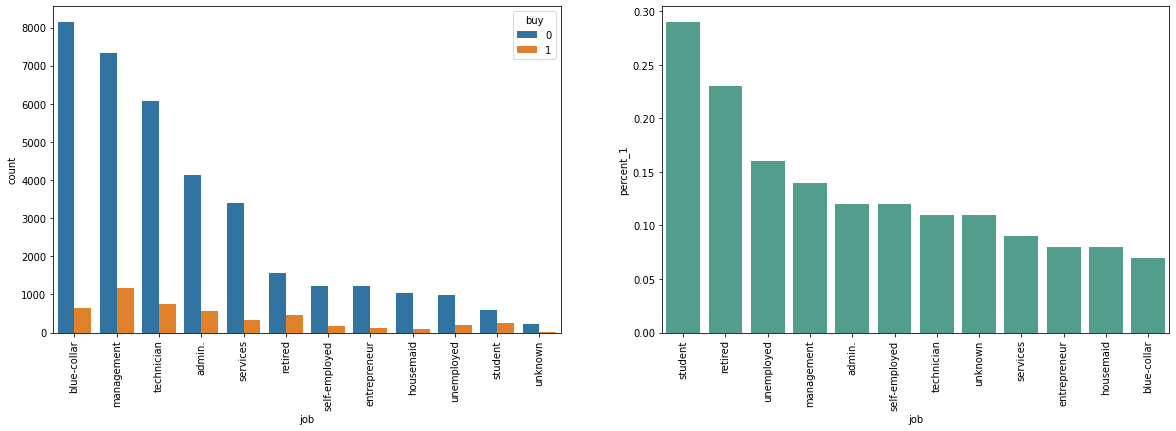

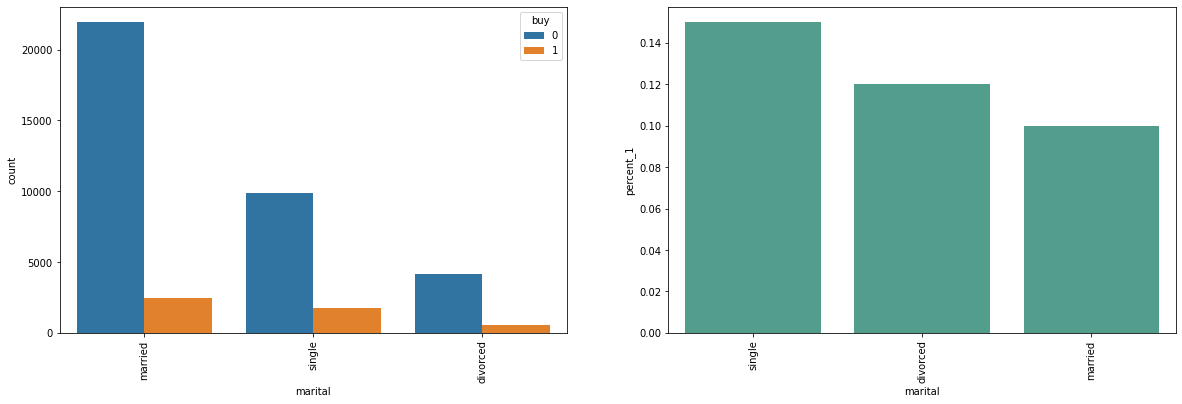

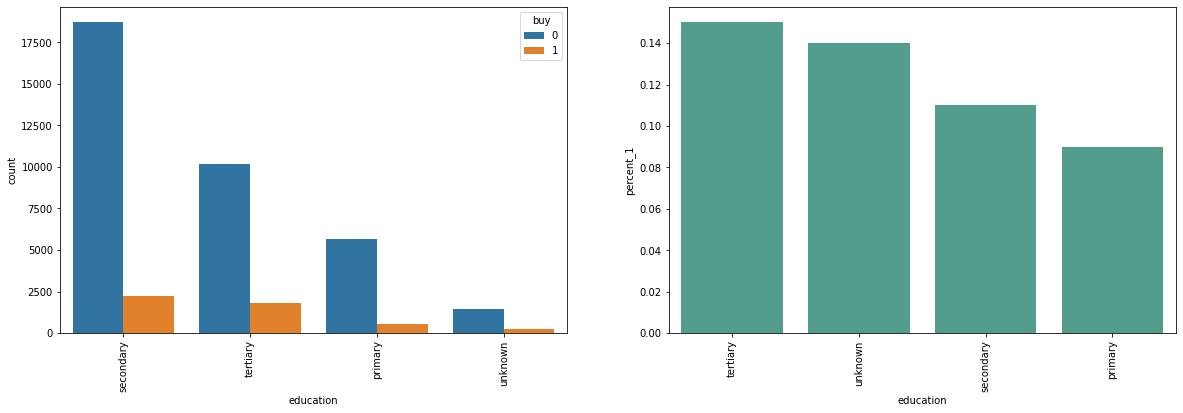

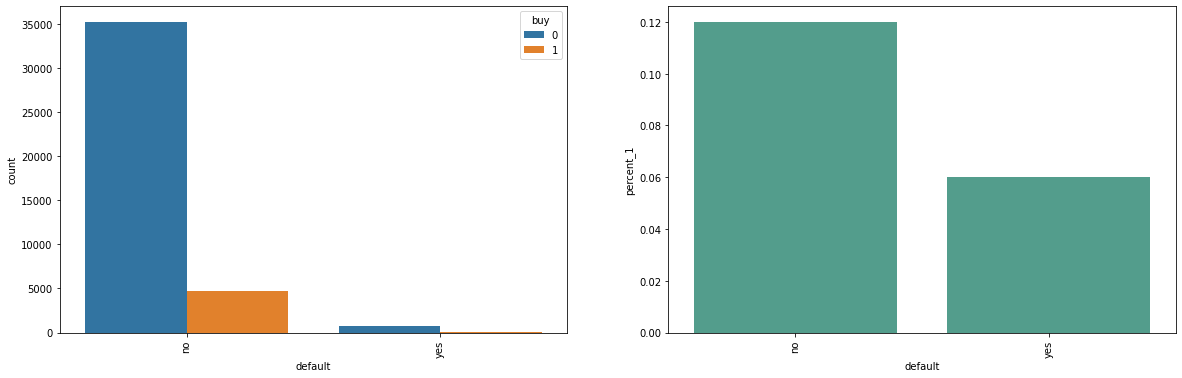

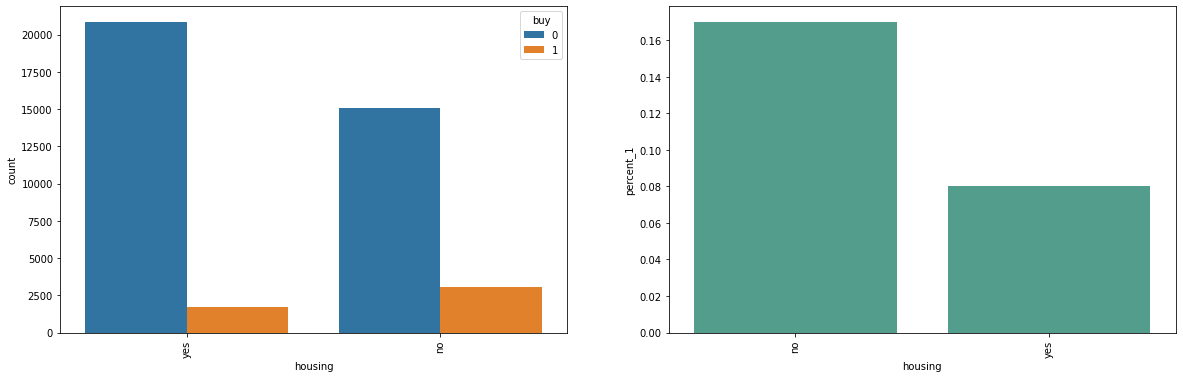

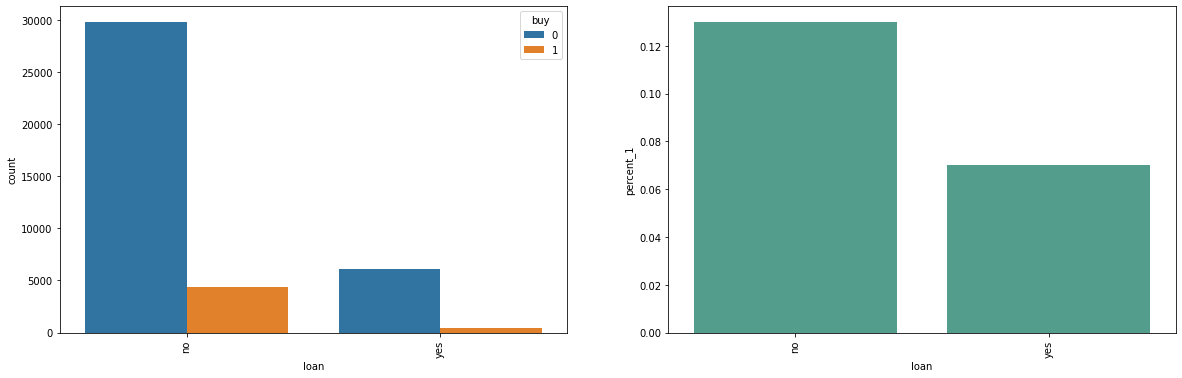

In [395]:
for col in client_cat_cols:
    cat_plot(data = df_train, col = col, class_ = 'buy')

**Findings on customer profile:**
- Student, retired & unemployed are groups that get highest percentage of owning a term-deposit, while blue-collar workers and entrepreneurs have low need for term-deposit amount.
- People who are not in marriage at the researching time (single or dirvoiced) want to get the term-deposit more than who are in.
- The higher final education level, the more probability that a client could create deposit account.
- Time deposit owners usually do not have house, loan, or get default credit, when the ratios of them generated from non-home, loan or credit are more than the against groups.
- Age and account balance are generally no different between buyers and non-buyers. One little contrast might be considered is: With some low-outliers who having a very big overdraft, they are definitely not buyers.

### About the current campaign

duration_min
       count      mean       std   min   25%    50%    75%    max
buy                                                              
0    35922.0  3.676804  3.450803  0.00  1.58  2.725   4.63  81.97
1     4768.0  8.926793  6.546214  0.13  4.03  7.060  12.00  64.68 

campaign
       count      mean       std  min  25%  50%  75%   max
buy                                                       
0    35922.0  2.844580  3.212825  1.0  1.0  2.0  3.0  63.0
1     4768.0  2.127307  1.902033  1.0  1.0  2.0  2.0  32.0 



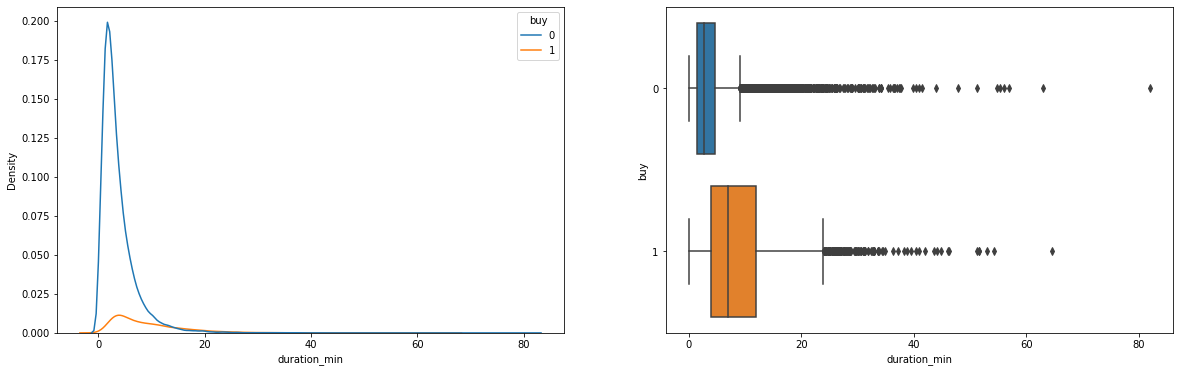

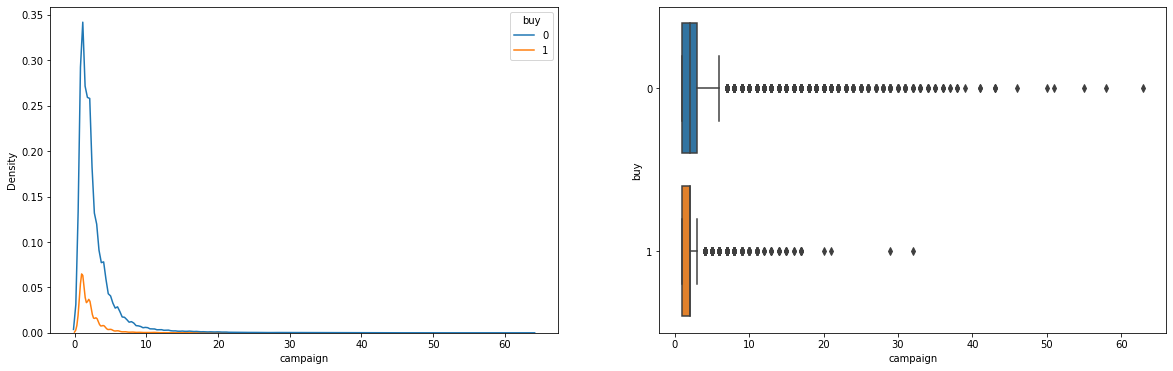

In [396]:
for col in curr_campaign_num_cols:
    num_plot(data = df_train, col = col, class_ = 'buy')

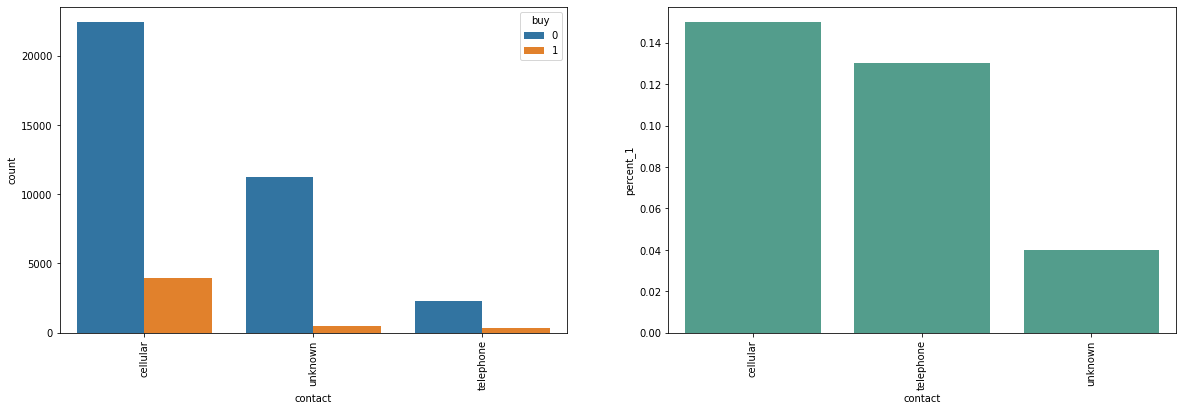

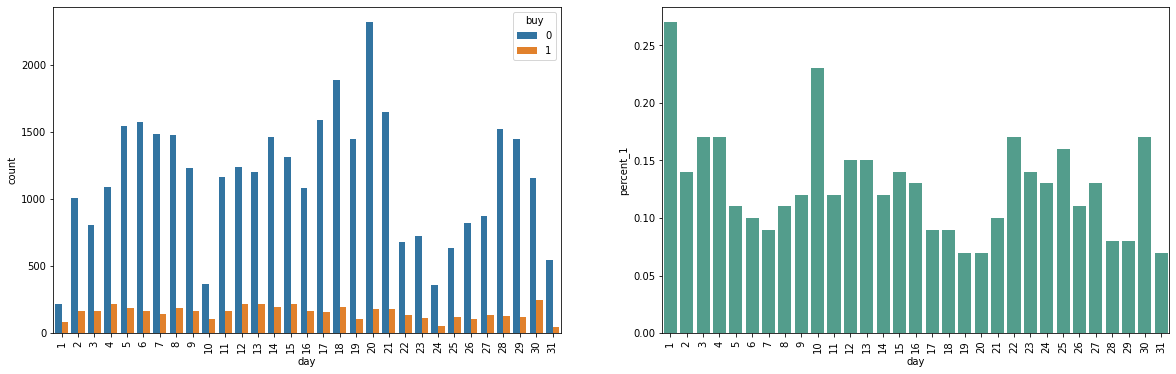

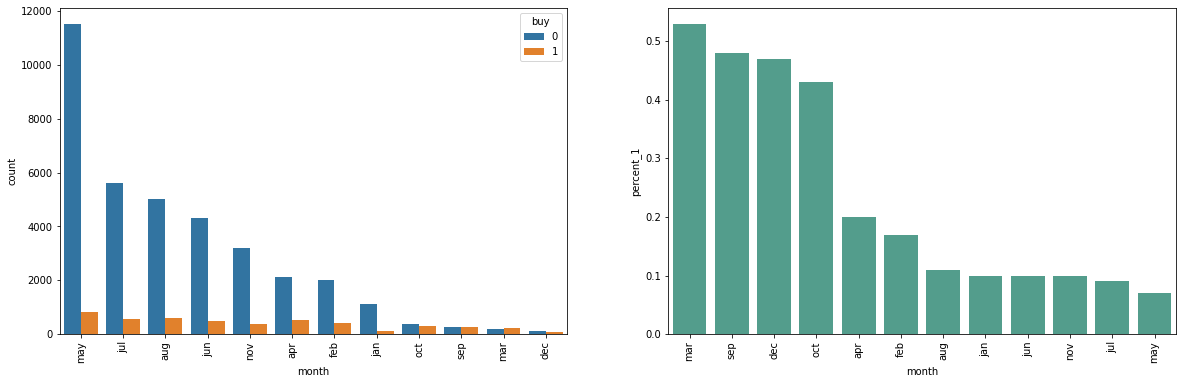

In [397]:
for col in curr_campaign_cat_cols:
    cat_plot(data=df_train, col=col, class_='buy')[0]

**Findings on the current campaign:**
* Contact clients through cellular got higher chance (nearly 15%) to be successful. While with the telephone, this number is around 13%.
* In the day 1 and 10 of month, the bank made very few contacts, but those days got highest performance in terms of buyers percentage (more than 20% of total approached clients gonna get term-deposit account). In the contrast, from day 18 to 20 are the most productive days but not effective like that, with the buyer conversion rates are under 10%. 
* There are very few contacts in Mar and months in Winter (Oct, Sep & Dec), but the number of buyer recorded as very high, nearly a half of total contacts. Months in Summer (May, July & June) are in the opposite side.
* Term-deposit owners are often clients whom contacted in 4 to 12 minutes. It's significantly longer than who not intend to buy, with only 1.5 - 4.5 minutes.

### About the last campaign

Last campaign happened when the value of attribute "previous" different 0.

In [398]:
df_train['pcampaign'] = df_train['previous'].apply(lambda x: 1 if x > 0 else 0)
df_train_last_campaign = df_train.loc[df_train['pcampaign'] == 1]

df_test['pcampaign'] = df_test['previous'].apply(lambda x: 1 if x > 0 else 0)

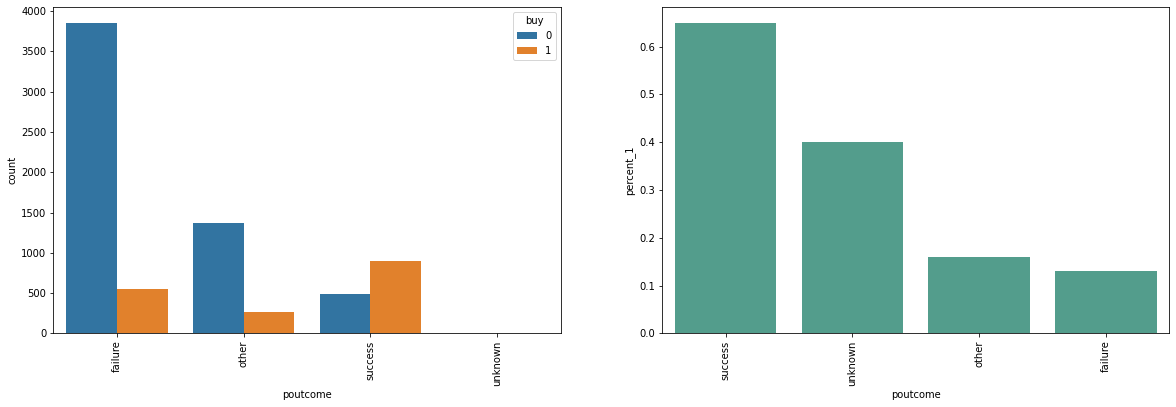

In [399]:
for col in last_campaign_cat_cols:
    cat_plot(data=df_train_last_campaign, col=col, class_='buy')[0]

pdays
      count        mean         std  min    25%    50%    75%    max
buy                                                                 
0    5720.0  234.299301  110.941585  1.0  153.0  234.0  335.0  850.0
1    1721.0  192.130157  122.718270  1.0   94.0  181.0  243.0  854.0 

previous
      count      mean       std  min  25%  50%  75%    max
buy                                                       
0    5720.0  3.175175  5.022044  1.0  1.0  2.0  4.0  275.0
1    1721.0  3.266705  3.455412  1.0  1.0  2.0  4.0   58.0 



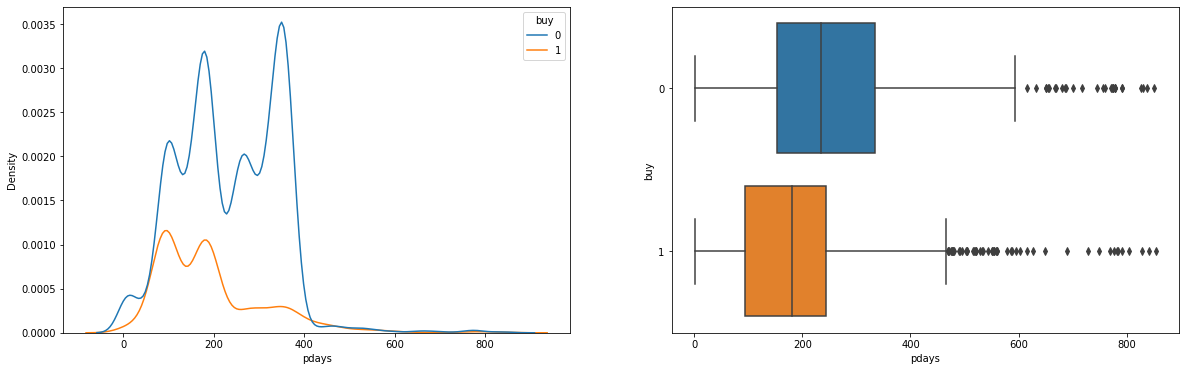

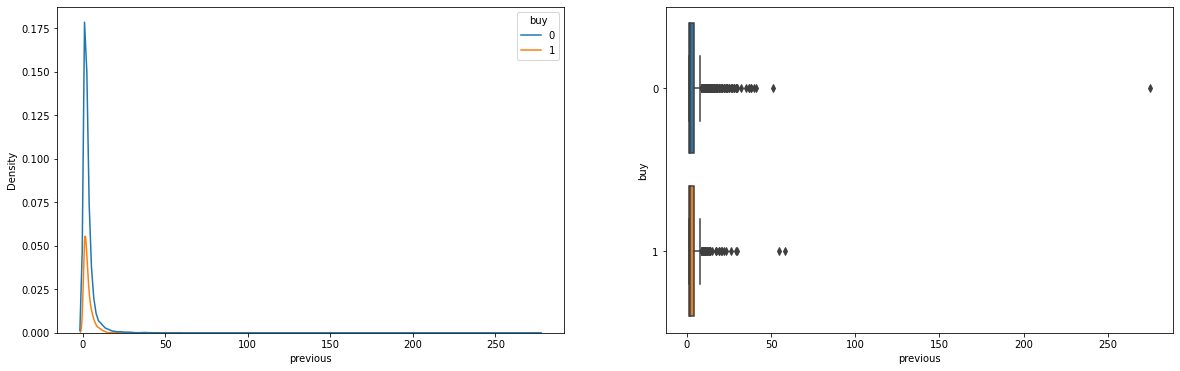

In [400]:
for col in last_campaign_num_cols:
    num_plot(data = df_train_last_campaign, col = col, class_ = 'buy')

previous
           count      mean       std  min  25%  50%  75%    max
poutcome                                                       
failure   4411.0  2.901610  3.152269  1.0  1.0  2.0  3.0   55.0
other     1643.0  4.083993  8.182317  1.0  1.0  2.0  4.0  275.0
success   1382.0  3.081042  2.596567  1.0  1.0  2.0  4.0   28.0
unknown      5.0  3.400000  2.509980  1.0  2.0  2.0  5.0    7.0 

pdays
           count        mean         std   min    25%    50%    75%    max
poutcome                                                                  
failure   4411.0  241.325096  111.189860   1.0  164.0  245.0  339.0  854.0
other     1643.0  230.918442  123.142701   1.0  142.0  232.0  335.0  838.0
success   1382.0  163.217077   95.397172   1.0   92.0  165.0  187.0  771.0
unknown      5.0  279.600000  183.119633  98.0  168.0  188.0  416.0  528.0 



array([<AxesSubplot:xlabel='pdays', ylabel='Density'>,
       <AxesSubplot:xlabel='pdays', ylabel='poutcome'>], dtype=object)

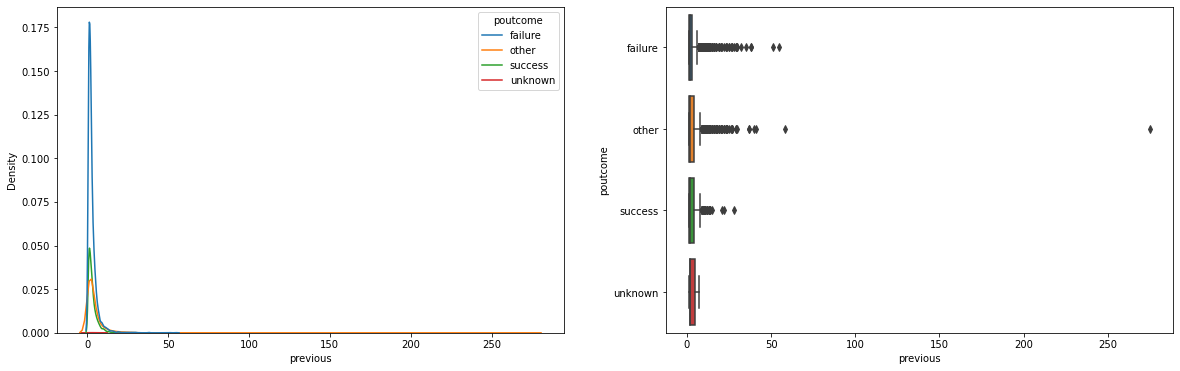

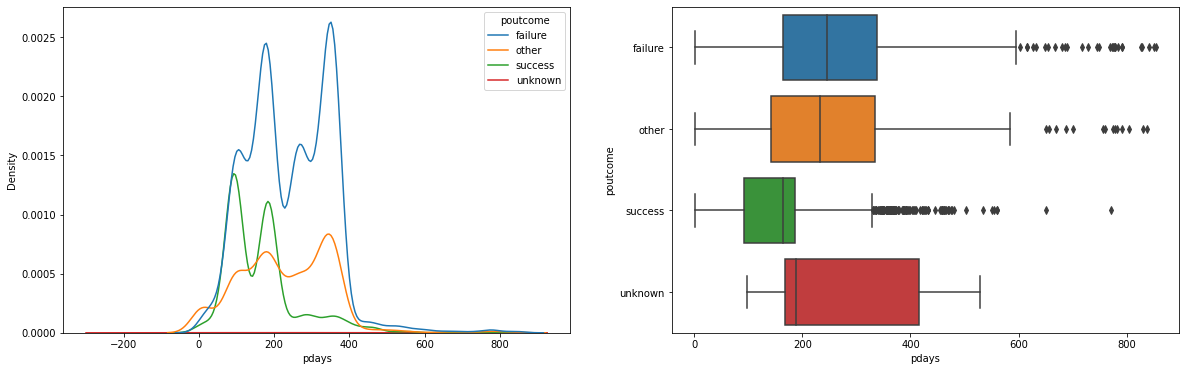

In [401]:
# Correlation between attributes of the last campaign
num_plot(data=df_train_last_campaign, col='previous', class_='poutcome')
num_plot(data=df_train_last_campaign, col='pdays', class_='poutcome')

previous
           count      mean       std  min  25%  50%  75%   max
poutcome                                                      
failure   4411.0  2.901610  3.152269  1.0  1.0  2.0  3.0  55.0
other     1642.0  3.919001  4.715697  1.0  1.0  2.0  4.0  58.0
success   1382.0  3.081042  2.596567  1.0  1.0  2.0  4.0  28.0
unknown      5.0  3.400000  2.509980  1.0  2.0  2.0  5.0   7.0 



array([<AxesSubplot:xlabel='previous', ylabel='Density'>,
       <AxesSubplot:xlabel='previous', ylabel='poutcome'>], dtype=object)

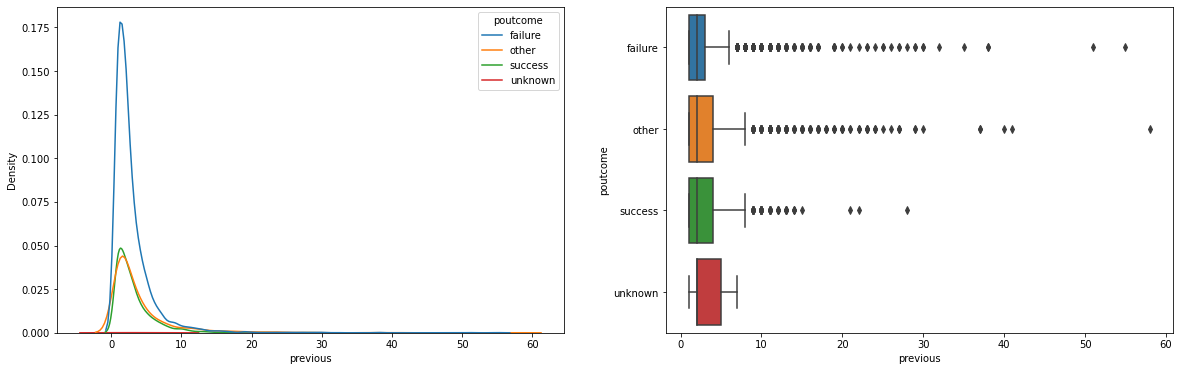

In [402]:
# For "Previous": Rescaling value range by removing some outlier more than 200 times. 
num_plot(data=df_train_last_campaign.loc[df_train_last_campaign['previous'] < 200], col='previous', class_='poutcome')

**Findings on the last campaign:**
* 60% of successful targeted customers from the last campaign, coming back and open another term-deposit account after this campaign. Failure or other status cases get only 20%.
* Almost successes are on the latest contacts which have gone for less 200 days.
* No difference between number of contacts in previous campaign with its outcome.

### Correlation between numeric attributes

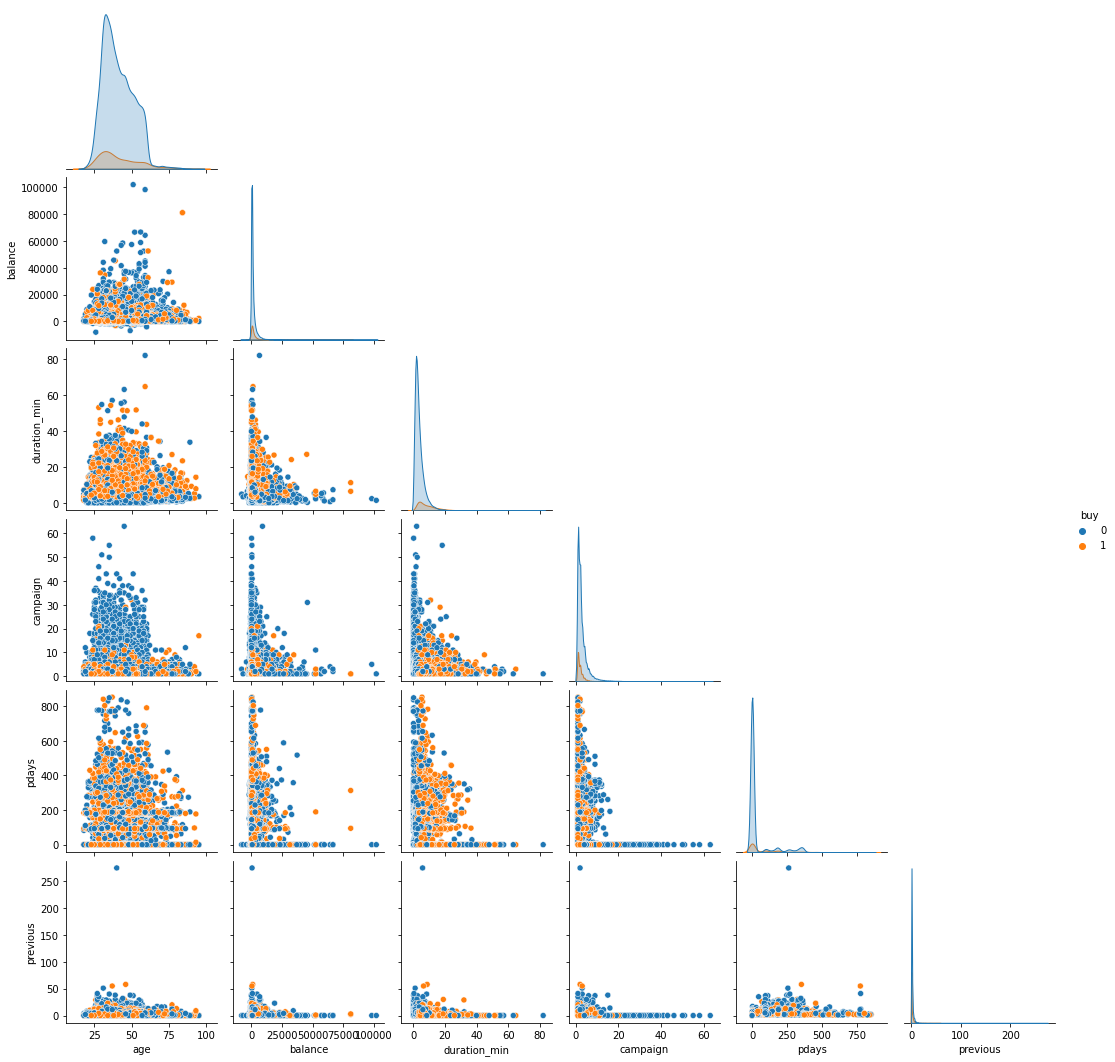

In [403]:
all_num_cols = client_num_cols + curr_campaign_num_cols + last_campaign_num_cols
# fig, ax = plt.subplots(figsize=(10,10))
sns.pairplot(df_train[all_num_cols + ['buy']], hue = 'buy', corner=True)

## Prediction

- Algorithms: XGBoost.
- Accuracy metric: F1-score. This metric is representative for both recall & precision. Since no specific priority on Error Types, both False Positive and False Negative should be reduced. 

**Features engineering strategy:**
- Categorical variables: one-hot encoding.
- Numeric variables: Keep original format.

In [404]:
# functions
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn import metrics

# algorithm
from xgboost import XGBClassifier

In [405]:
# metrics functions
def confusion_matrix_plot(y_train_true, y_test_true, y_train_pred, y_test_pred):
    fig, axes = plt.subplots(1, 2, figsize=(20,6))
    sns.heatmap(
        metrics.confusion_matrix(y_train_true, y_train_pred, labels=[1,0]),
        annot=True,
        fmt="g",
        cmap="Greens",
        cbar=False,
        annot_kws={"size": 14},
        ax = axes[0]
    )
    axes[0].set_title('train set')

    sns.heatmap(
        metrics.confusion_matrix(y_test_true, y_test_pred, labels=[1,0]),
        annot=True,
        fmt="g",
        cmap="Greens",
        cbar=False,
        annot_kws={"size": 14},
        ax = axes[1]
    )
    axes[1].set_title('test set')

    return axes

In [406]:
df_train_1 = df_train.copy()
df_test_1 = df_test.copy()

In [407]:
one_hot = OneHotEncoder(handle_unknown='ignore', drop='if_binary')
for col in ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome', 'month', 'day']:
    one_hot.fit(df_train_1[[col]])

    df_train_1 = pd.merge(
        df_train_1.reset_index(drop=True),
        pd.DataFrame(one_hot.transform(df_train_1[[col]]).toarray(), columns = one_hot.get_feature_names_out()),
        left_index=True,
        right_index=True,
        how='inner').drop(col, axis = 1)

    df_test_1 = pd.merge(
        df_test_1.reset_index(drop=True),
        pd.DataFrame(one_hot.transform(df_test_1[[col]]).toarray(), columns = one_hot.get_feature_names_out()),
        left_index=True,
        right_index=True,
        how='inner').drop(col, axis = 1)

not_for_training_cols = ['identity_key']
df_train_1 = df_train_1.loc[:, [col for col in df_train_1.columns if col not in not_for_training_cols]]
df_test_1 = df_test_1.loc[:, [col for col in df_test_1.columns if col not in not_for_training_cols]]
print("train:", len(df_train_1.columns), "features")
print("test:", len(df_test_1.columns), "features")

train: 80 features
test: 80 features


In [408]:
# first try the model with default parameters
model_1 = XGBClassifier(objective = 'binary:logistic', random_state=26)
# model_1 = sklearn.svm.SVC(random_state=26)
model_1.fit(X=df_train_1.loc[:, df_train_1.columns != 'buy'], y=df_train_1['buy'])
y_pred_1 = model_1.predict(df_test_1.loc[:, df_test_1.columns != 'buy'])
y_train_pred_1 = model_1.predict(df_train_1.loc[:, df_train_1.columns != 'buy'])

In [409]:
print("f1 score on train set:", metrics.f1_score(df_train_1['buy'], y_train_pred_1, pos_label=1))
print("f1 score on test set:", metrics.f1_score(df_test_1['buy'], y_pred_1, pos_label=1))

f1 score on train set: 0.7621922898281468
f1 score on test set: 0.5357917570498916


array([<AxesSubplot:title={'center':'train set'}>,
       <AxesSubplot:title={'center':'test set'}>], dtype=object)

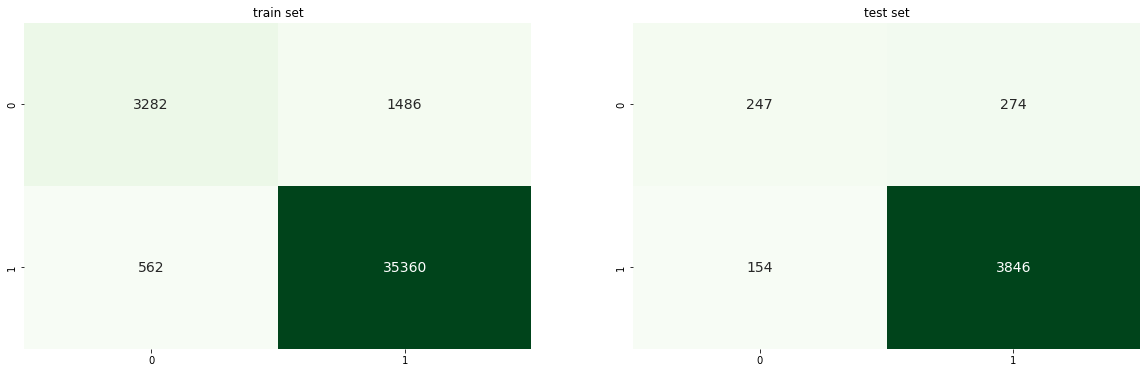

In [410]:
confusion_matrix_plot(df_train_1['buy'], df_test_1['buy'], y_train_pred_1, y_pred_1)

In [411]:
fea_imp_1 = pd.DataFrame({'feature': df_train_1.loc[:, [col for col in df_train_1.columns if col not in ['buy', 'duration_sec', 'identity_key']]].columns,
                    'score': model_1.feature_importances_})
fea_imp_1.sort_values(by='score', ascending=False).head(30)

,feature,score
34,poutcome_success,0.165592
31,contact_unknown,0.058962
43,month_mar,0.040464
5,duration_min,0.032974
42,month_jun,0.028404
27,housing_yes,0.027290
36,month_apr,0.026260
47,month_sep,0.025643
46,month_oct,0.022776
38,month_dec,0.022185


Many day's features in the top of importance list, that affect to how trees decided. Next step, reducing the unique values of this column by grouping particular values into bins.

In [412]:
# check cardinality level of variables
cardinality_df = pd.DataFrame({'column': df_train.columns})
cardinality_df['unique_values'] = cardinality_df['column'].apply(lambda col: len(df_train[col].unique()))
cardinality_df.sort_values(by='unique_values', ascending=False)

,column,unique_values
5,balance,6877
16,duration_min,1538
12,pdays,544
0,age,77
11,campaign,47
13,previous,41
9,day,31
1,job,12
10,month,12
3,education,4


Days with 31 unique values should be grouping into 3 categories: first 10 days, middle 10 days, and last 10 days.

In [413]:
def make_day_bins(df):
    df_copy = df.copy()

    # grouping day values into 3 bins
    df_copy.loc[(df_copy['day'] >= 1 ) & (df_copy['day'] <= 10 ), 'day_bin'] = 'first_10_days'
    df_copy.loc[(df_copy['day'] >= 11 ) & (df_copy['day'] <= 20 ), 'day_bin'] = 'mid_10_days'
    df_copy.loc[(df_copy['day'] >= 21 ) & (df_copy['day'] <= 31 ), 'day_bin'] = 'last_10_days'
    
    return df_copy

df_train_2 = make_day_bins(df_train)
df_test_2 = make_day_bins(df_test)

In [414]:
# encoding
one_hot = OneHotEncoder(handle_unknown='ignore', drop='if_binary')
for col in ['job', 'education', 'marital', 'default', 'housing', 'loan', 'contact', 'poutcome', 'month', 'day_bin']:
    one_hot.fit(df_train_2[[col]])

    df_train_2 = pd.merge(
        df_train_2.reset_index(drop=True),
        pd.DataFrame(one_hot.transform(df_train_2[[col]]).toarray(), columns = one_hot.get_feature_names_out()),
        left_index=True,
        right_index=True,
        how='inner').drop(col, axis = 1)

    df_test_2 = pd.merge(
        df_test_2.reset_index(drop=True),
        pd.DataFrame(one_hot.transform(df_test_2[[col]]).toarray(), columns = one_hot.get_feature_names_out()),
        left_index=True,
        right_index=True,
        how='inner').drop(col, axis = 1)


not_for_training_cols = ['identity_key', 'day', 'month', 'month_bin', 'day_bin']
df_train_2 = df_train_2.loc[:, [col for col in df_train_2.columns if col not in not_for_training_cols]]
df_test_2 = df_test_2.loc[:, [col for col in df_test_2.columns if col not in not_for_training_cols]]
print("train:", len(df_train_2.columns), "features")
print("test:", len(df_test_2.columns), "features")

train: 52 features
test: 52 features


In [415]:
df_train_2.columns

Index(['age', 'balance', 'campaign', 'pdays', 'previous', 'buy',
       'duration_min', 'pcampaign', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'education_primary',
       'education_secondary', 'education_tertiary', 'education_unknown',
       'marital_divorced', 'marital_married', 'marital_single', 'default_yes',
       'housing_yes', 'loan_yes', 'contact_cellular', 'contact_telephone',
       'contact_unknown', 'poutcome_failure', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'day_bin_first_10_days', 'day_bin_last_10_days', 'day_bin_mid_10_days'],
      dtype='object')

In [416]:
model_2 = XGBClassifier(objective='binary:logistic', random_state=26)
model_2.fit(X=df_train_2.loc[:, df_train_2.columns != 'buy'], y=df_train_2['buy'])
y_pred_2 = model_2.predict(df_test_2.loc[:, df_test_2.columns != 'buy'])
y_train_pred_2 = model_2.predict(df_train_2.loc[:, df_train_2.columns != 'buy'])

In [417]:
print("f1 score on train set:", metrics.f1_score(df_train_2['buy'], y_train_pred_2, pos_label=1))
print("f1 score on test set:", metrics.f1_score(df_test_2['buy'], y_pred_2, pos_label=1))

f1 score on train set: 0.7666860803727431
f1 score on test set: 0.5680600214362271


array([<AxesSubplot:title={'center':'train set'}>,
       <AxesSubplot:title={'center':'test set'}>], dtype=object)

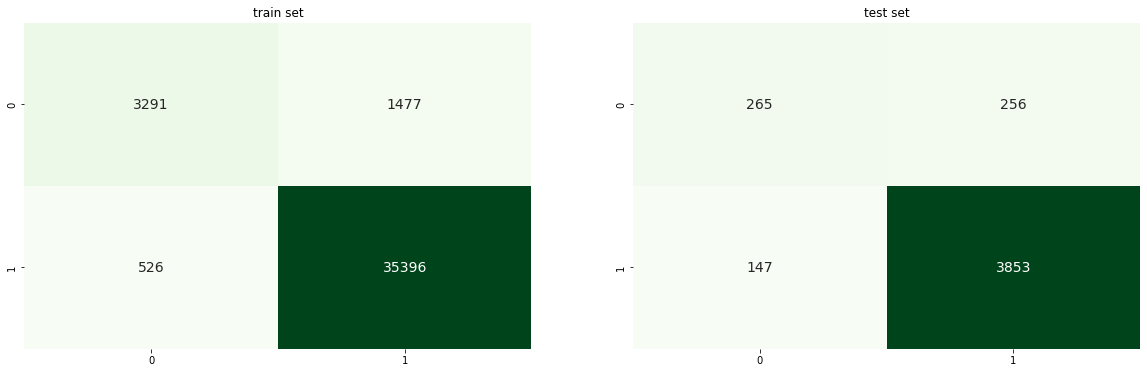

In [418]:
confusion_matrix_plot(df_train_2['buy'], df_test_2['buy'], y_train_pred_2, y_pred_2)

The f1 score on test set is better, from 0.53 to 0.57.

In [419]:
fea_imp_2 = pd.DataFrame({'feature': df_train_2.loc[:, [col for col in df_train_2.columns if col not in ['buy', 'duration_sec', 'identity_key']]].columns,
                    'score': model_2.feature_importances_})
fea_imp_2.sort_values(by='score', ascending=False).head(30)

,feature,score
34,poutcome_success,0.169991
31,contact_unknown,0.090483
43,month_mar,0.057556
27,housing_yes,0.042544
5,duration_min,0.040287
42,month_jun,0.037797
46,month_oct,0.037029
35,poutcome_unknown,0.035207
36,month_apr,0.032165
38,month_dec,0.030647


#### Hyperparameters optimization

In [420]:
# set up parameters grid
params = {
        'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],     # try with range around default value: 0.3 
        'min_child_weight': [3, 5, 9, 13, 17],        # decrease overfitting
        'max_depth': [6,7,8,9,10],                          # decrease overfitting
        'scale_pos_weight': [1,2,3,4]                    # increase weight of minority class (buyer) due to imbalance class ratio
        }

params_result = pd.DataFrame(columns=list(params.keys()) + ['f1', 'recall', 'precision'])
for pr in list(ParameterGrid(params)):
        new_result = pd.DataFrame(pr, index=[0])

        model_2 = XGBClassifier(objective = 'binary:logistic', tree_method='hist', random_state=26, **pr)    # change tree_method with hist value to fasten the process
        model_2.fit(X=df_train_2.loc[:, df_train_2.columns != 'buy'], y=df_train_2['buy'])
        y_pred = model_2.predict(df_test_2.loc[:, df_test_2.columns != 'buy'])
        new_result['f1'] = metrics.f1_score(df_test_2['buy'], y_pred, pos_label=1)
        new_result['recall'] = metrics.recall_score(df_test_2['buy'], y_pred, pos_label=1)
        new_result['precision'] = metrics.precision_score(df_test_2['buy'], y_pred, pos_label=1)

        params_result = pd.concat([
                params_result,
                new_result
        ], axis = 0)

In [421]:
best_params = (
    params_result.reset_index(drop=True)
    .sort_values(by='f1', ascending=False).reset_index(drop=True)
    .iloc[0]
)[['learning_rate', 'min_child_weight', 'max_depth', 'scale_pos_weight']].to_dict()
best_params

{'learning_rate': 0.3,
 'min_child_weight': 17,
 'max_depth': 6,
 'scale_pos_weight': 2}

In [422]:
best_estimator = XGBClassifier(objective='binary:logistic', tree_method='hist', random_state=26, verbosity=0,
                           **best_params)
best_estimator.fit(df_train_2.loc[:, df_train_2.columns != 'buy'], df_train_2['buy'])
y_pred_2a = best_estimator.predict(df_test_2.loc[:, df_test_2.columns != 'buy'])
y_train_pred_2a = best_estimator.predict(df_train_2.loc[:, df_train_2.columns != 'buy'])

In [423]:
print("f1 score on train set:", metrics.f1_score(df_train_2['buy'], y_train_pred_2a, pos_label=1))
print("f1 score on test set:", metrics.f1_score(df_test_2['buy'], y_pred_2a, pos_label=1))

f1 score on train set: 0.7252048192771084
f1 score on test set: 0.6212251941328731


array([<AxesSubplot:title={'center':'train set'}>,
       <AxesSubplot:title={'center':'test set'}>], dtype=object)

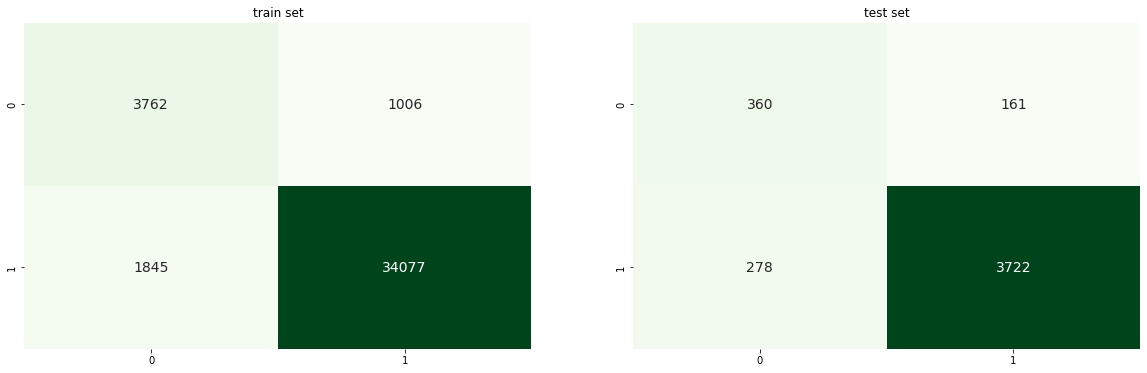

In [424]:
confusion_matrix_plot(df_train_2['buy'], df_test_2['buy'], y_train_pred_2a, y_pred_2a)

The f1 score increases to 0.62. The model intend to predict more class 1, so the number of True Positive goes up, but False Positive increase too. 

**Suggestions for further improvement:**
- Class balancing: Beside modifying parameter scale_pos_weight in XGBoost, other libraries (ex: imblearn) could be used to directly modify detailed class ratio or sampling strategy for dataset.
- Not many variables in the dataset got significant difference between 2 classes, lead to too many features related to day and month appear in top of features importance and repulse the rest ones. New variables should be appended to improve prediction accuracy.